In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
from google.colab import files
import struct
from array import array
import torch.optim as optim
import torch
import torch.nn as nn

In [ ]:
train_data = files.upload()
train_labels= files.upload()
test_data= files.upload()
test_labels= files.upload()

train_data_name= 'train-images-idx3-ubyte'
train_labels_name= 'train-labels-idx1-ubyte'
test_data_name= 't10k-images-idx3-ubyte'
test_labels_name = 't10k-labels-idx1-ubyte'

In [ ]:
#
# Load MNIST data
#
class MnistDataloader(object):
    def __init__(self, training_data_file,training_labels_file, test_data_file, test_labels_file):
        self.training_data_file = training_data_file
        self.training_labels_file = training_labels_file
        self.test_data_file = test_data_file
        self.test_labels_file = test_labels_file
    
    def read_images_labels(self, features_file, target_file):        
        labels = []
        with open(target_file, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Mismatch! Expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(features_file, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Mismatch! Expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            #print('image size: ', img.shape)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_data_file, self.training_labels_file)
        x_test, y_test = self.read_images_labels(self.test_data_file, self.test_labels_file)
        return (x_train, y_train),(x_test, y_test) 

In [ ]:
mnist_dataloader = MnistDataloader(train_data_name, train_labels_name, test_data_name, test_labels_name)
(train_X, train_labels), (test_X, test_labels) = mnist_dataloader.load_data()

(train_X, train_labels), (test_X, test_labels) = mnist_dataloader.load_data()

train_X= np.array(train_X, dtype="int")
train_labels= np.array(train_labels, dtype="int").reshape(-1, 1)
test_X= np.array(test_X,dtype="int")
test_labels= np.array(test_labels, dtype="int").reshape(-1, 1)

#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_labels.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_labels.shape))

X_train: (60000, 28, 28)
Y_train: (60000, 1)
X_test:  (10000, 28, 28)
Y_test:  (10000, 1)


In [ ]:
def cal_gradient_loss(X, y, W, batch):
    y_pred= np.dot(X, W)
    error= (y - y_pred) 
    grad= np.dot(X.T, error)
    grad = grad/batch
    loss= np.sum(np.sum(((1/2) * ((error)**2)), axis=0))/batch 
    return grad, loss

In [ ]:
def cal_accuracy_test_error(test_X, test_y, W):
    y_test_predict= np.dot(test_X, W)
    test_error=  np.sum(np.sum(((1/2) * ((test_y - y_test_predict)**2))) / test_y.shape[0])

    y_test_predict= np.argmax(y_test_predict, axis=1)
    y_actual= np.argmax(test_y, axis=1)

    acc= round((sum(y_test_predict == y_actual)/ test_y.shape[0]) *100, 3)

    return acc , test_error

In [ ]:
def SGD(x_train, y_train, test_X, test_y, batch, eta= 0.0001, itr=500 ):
    train_loss=[]
    W= np.zeros((x_train.shape[1], 10))

    train_loss= []
    test_accuracy=[]
    test_error_list= []
    for i in range(itr):
        samples= np.random.choice(np.arange(0, x_train.shape[0]), batch, replace=True)
        X= x_train[samples]
        y= y_train[samples]

        grad, loss = cal_gradient_loss(X, y, W, batch)
        W= W + (eta * grad)
        train_loss.append(loss)

        accuracy, test_error= cal_accuracy_test_error(test_X, test_y, W)

        test_accuracy.append(accuracy)
        test_error_list.append(test_error)
    return train_loss, test_accuracy, test_error_list


In [ ]:
#nomralize data and on-hot-enocde labels
train_X= train_X.reshape(train_X.shape[0], 784)
test_X= test_X.reshape(test_X.shape[0], 784)
train_X= train_X/255
test_X= test_X/255

#Creating a 10 dimensional label for each data in Train and Test set
classes = np.arange(10)
train_y = (classes == train_labels).astype(np.int)
test_y = (classes == test_labels).astype(np.int)

To pick a choice of learning rate we initally run for a fixed number of batch and iteration. 
We pick batch as 100 and iteration as 1000 and plot training loss and test loss for each learning rate.  
I pick a descent data size of 20000 to find out best learning rate.

For batch size: 100 learning rate 0.01: training took 39.49 seconds. Accuracy = 84.85%
For batch size: 100 learning rate 0.02: training took 39.755 seconds. Accuracy = 84.75%
For batch size: 100 learning rate 0.001: training took 43.356 seconds. Accuracy = 79.98%
For batch size: 100 learning rate 0.002: training took 37.407 seconds. Accuracy = 82.41%
For batch size: 100 learning rate 0.0001: training took 37.837 seconds. Accuracy = 75.85%
For batch size: 100 learning rate 1e-05: training took 36.509 seconds. Accuracy = 69.49%


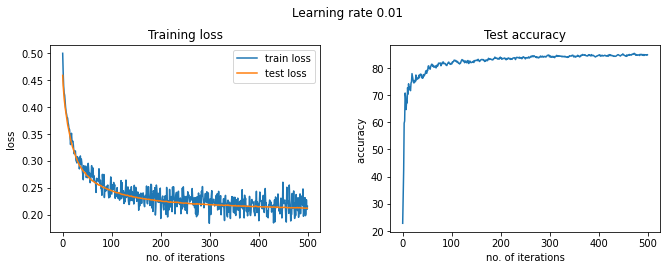

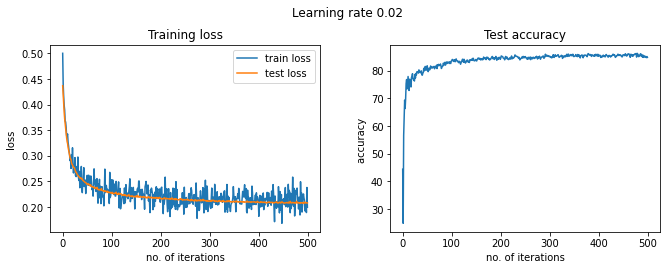

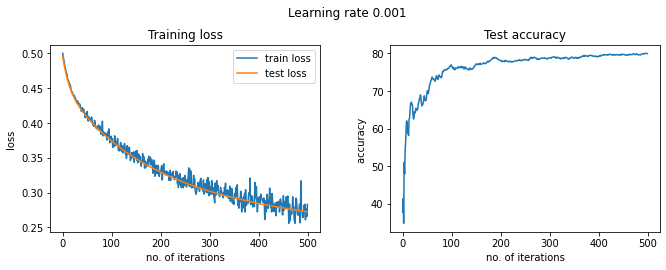

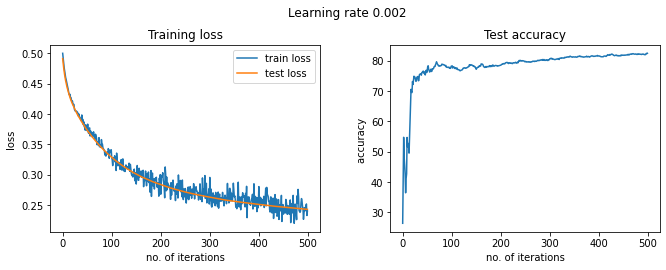

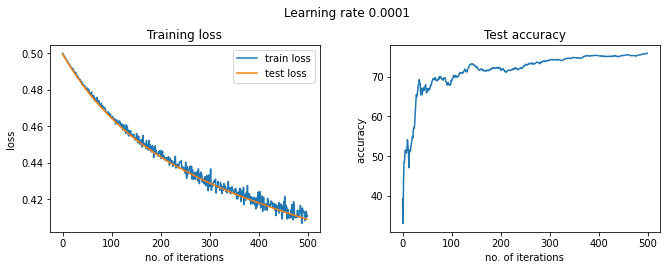

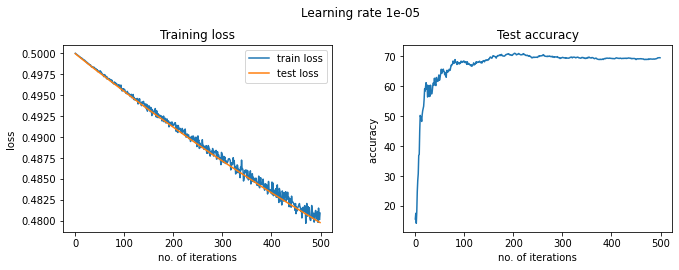

In [ ]:
learning_rates = [0.01, 0.02, 0.001, 0.002, 0.0001, .00001]

random.seed(20)
for lr in learning_rates:
  
	t1= time.time()
	train_loss, accuracy, test_error= SGD(train_X, train_y, test_X, test_y, 100, lr, 500)
	t2= time.time()
	time_delta= round((t2-t1), 3)
	print('For batch size: {0} learning rate {1}: training took {2} seconds. Accuracy = {3}%'.format(100,  lr, time_delta, accuracy[-1]))

	fig, axs = plt.subplots(1,2, figsize= [10,4])
	fig.tight_layout(pad=4.0)
	fig.suptitle('Learning rate '+ str(lr))
	axs[0].plot(train_loss, label='train loss')
	axs[0].plot(test_error, label='test loss')
	axs[0].set_title('Training loss')
	axs[0].set_ylabel('loss ')
	axs[0].set_xlabel('no. of iterations')
	axs[1].plot(accuracy)
	axs[1].set_title('Test accuracy')
	axs[1].set_ylabel('accuracy ')
	axs[1].set_xlabel('no. of iterations')
	axs[0].legend()

Since, 0.02 gave good accuracy, we will use 0.02 as our learning rate for further executions. 

For batch size: 1 learning rate 0.02: training took 158.091 seconds. Accuracy = 13.89%


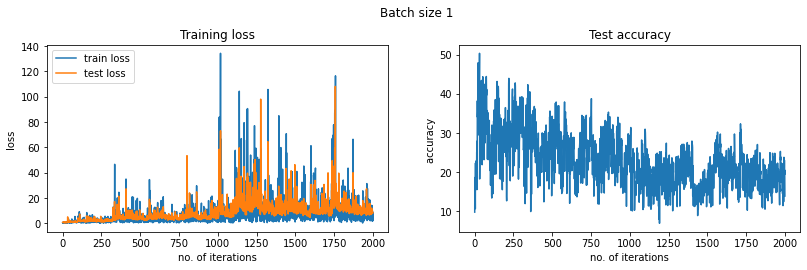

For batch size: 10 learning rate 0.02: training took 155.906 seconds. Accuracy = 82.74%


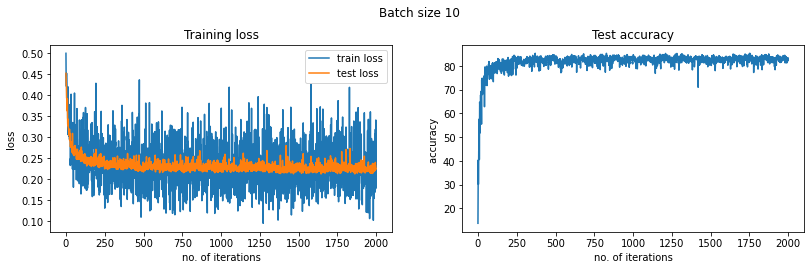

For batch size: 100 learning rate 0.02: training took 154.845 seconds. Accuracy = 85.98%


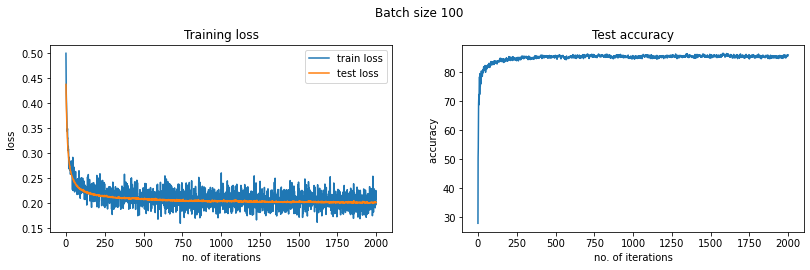

For batch size: 1000 learning rate 0.02: training took 170.845 seconds. Accuracy = 85.73%


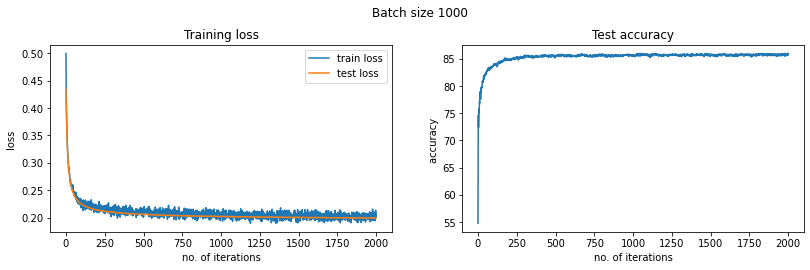

In [ ]:
#using zero weight initialization

batchsize= [1, 10, 100, 1000]
lr= 0.02
iter=2000

random.seed(20)
for batch in batchsize:
    t1= time.time()
    train_loss, accuracy, test_error= SGD(train_X, train_y, test_X, test_y, batch, lr, iter)

    t2= time.time()
    time_delta= round((t2-t1), 3)
    print('For batch size: {0} learning rate {1}: training took {2} seconds. Accuracy = {3}%'.format(batch,    lr, time_delta, accuracy[-1]))


    fig, axs = plt.subplots(1,2, figsize= [12,4])
    fig.tight_layout(pad=4.0)
    fig.suptitle('Batch size '+ str(batch))
    axs[0].plot(train_loss, label='train loss')
    axs[0].plot(test_error, label='test loss')
    axs[0].set_title('Training loss')
    axs[0].set_ylabel('loss ')
    axs[0].set_xlabel('no. of iterations')
    axs[1].plot(accuracy)
    axs[1].set_title('Test accuracy')
    axs[1].set_ylabel('accuracy ')
    axs[1].set_xlabel('no. of iterations')
    axs[0].legend()
    plt.show()

Role of Batch Size: For a fixed number of iterations, as the batch size is increasing the accuracy increases. But as the product of batch size and number of iterations are getting closer to dataset size then the accuracy stabilizes.

For dataset size: 100 batch size: 100 learning rate 0.02: training took 155.3 seconds. Accuracy = 59.53%


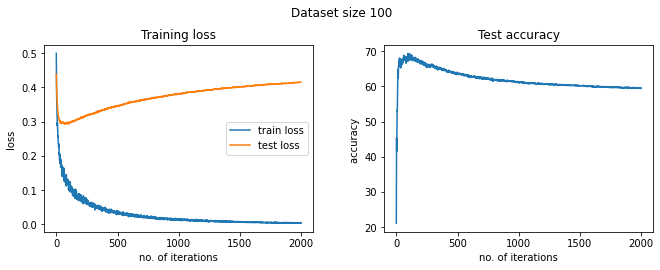

For dataset size: 500 batch size: 100 learning rate 0.02: training took 155.859 seconds. Accuracy = 77.98%


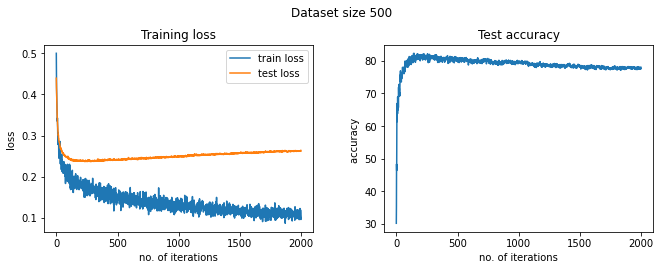

For dataset size: 1000 batch size: 100 learning rate 0.02: training took 156.838 seconds. Accuracy = 81.64%


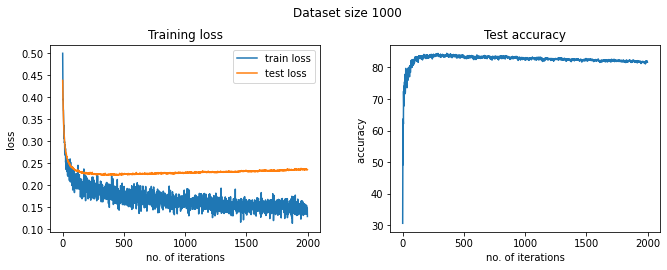

For dataset size: 10000 batch size: 100 learning rate 0.02: training took 157.642 seconds. Accuracy = 84.99%


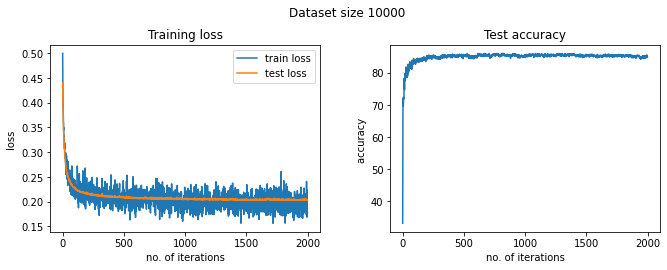

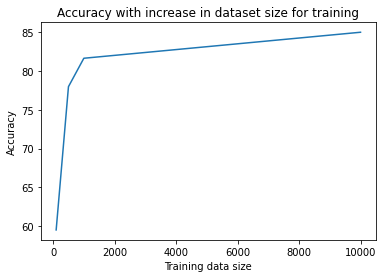

In [ ]:
training_dataset_size= [100, 500, 1000, 10000]
batch= 100
lr= 0.02
iter= 2000

accuracy_dt= []

random.seed(20)
for dt_size in training_dataset_size:
	samples= np.random.choice(np.arange(0, train_X.shape[0]), dt_size, replace=False)
	x_train= train_X[samples]
	y_train= train_y[samples]
	t1= time.time()
	train_loss, accuracy, test_error= SGD(x_train, y_train, test_X, test_y, batch, lr, iter)
	t2= time.time()
	time_delta= round((t2-t1), 3)
	print('For dataset size: {0} batch size: {1} learning rate {2}: training took {3} seconds. Accuracy = {4}%'.format(dt_size, batch,	lr, time_delta, accuracy[-1]))
	accuracy_dt.append(accuracy[-1])
	
	fig, axs = plt.subplots(1,2, figsize= [10,4])
	fig.tight_layout(pad=4.0)
	fig.suptitle('Dataset size '+ str(dt_size))
	axs[0].plot(train_loss, label='train loss')
	axs[0].plot(test_error, label='test loss')
	axs[0].set_title('Training loss')
	axs[0].set_ylabel('loss ')
	axs[0].set_xlabel('no. of iterations')
	axs[1].plot(accuracy)
	axs[1].set_title('Test accuracy')
	axs[1].set_ylabel('accuracy ')
	axs[1].set_xlabel('no. of iterations')
	axs[0].legend()
 
	plt.show()

plt.title("Accuracy with increase in dataset size for training")

plt.plot(training_dataset_size, accuracy_dt)
plt.xlabel('Training data size')
plt.ylabel('Accuracy')
plt.show()

Role of Dataset Size: As we train on bigger dataset set our model becomes more accurate in predicting and we get higher accuracy on test data.

In [ ]:
# Using Pytorch

Time taken for training:  23.207 seconds and final accuracy is 63.92


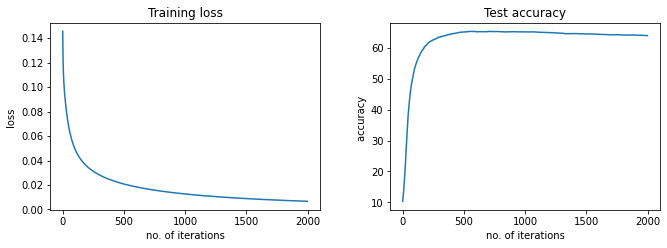

In [ ]:
#converting numpy to tensor
input_train= torch.Tensor(train_X)
target_train = torch.Tensor(train_y)

input_test= torch.Tensor(test_X)
target_test = torch.Tensor(test_labels)

input_train= input_train.view(input_train.shape[0], -1)
target_train = target_train.view(target_train.shape[0], -1)

input_test= input_test.view(input_test.shape[0], -1)
target_test = target_test.view(target_test.shape[0], -1)

#declaring model, loss function and learning rate
model = torch.nn.Linear(28*28, 10)
criterion = nn.MSELoss() 
optimizer = optim.SGD(model.parameters(), lr=0.02)

train_loss = []
test_accuracy= []

random.seed(20)
t1= time.time()
for epoch in range(2000):
    batch_rand_index=np.random.choice(input_train.shape[0], 100, replace=False)
    input_train= input_train[batch_rand_index]
    target_train= target_train[batch_rand_index]

    output = model(input_train)
    loss = criterion(output, target_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #if epoch%100 ==0:
    #    print('loss in iteration {0} = {1}'.format(epoch, loss.item()))

    train_loss.append(loss.item())


    #prediction
    y_pred = model(input_test)
    _, predicted = torch.max(y_pred.data, 1)
    predicted= predicted.view(-1, 1)
    correct = (predicted == target_test).sum().item()
    total= predicted.size()[0]
    accuracy= 100 * correct / total
    test_accuracy.append(accuracy)
t2= time.time()
time_delta= round((t2-t1), 3)

print('Time taken for training:  {0} seconds and final accuracy is {1} '.format(time_delta, test_accuracy[-1]) )
fig, axs = plt.subplots(1,2, figsize= [10,4])
fig.tight_layout(pad=4.0)
axs[0].plot(train_loss, label='train loss')
axs[0].set_title('Training loss')
axs[0].set_ylabel('loss ')
axs[0].set_xlabel('no. of iterations')
axs[1].plot(test_accuracy)
axs[1].set_title('Test accuracy')
axs[1].set_ylabel('accuracy ')
axs[1].set_xlabel('no. of iterations')
plt.show()

The accuracy for batch size 100 comes out to be nearly same which proves our hard-coded algorithm to be true.